In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])


c:\users\navpr\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([512, 1, 28, 28])
torch.Size([512])


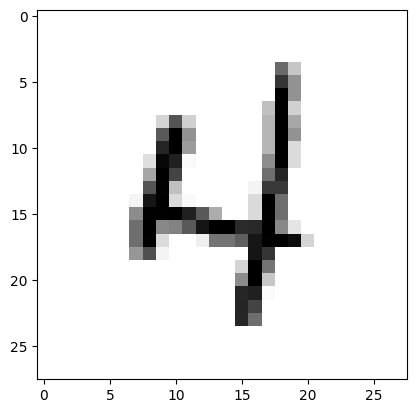

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


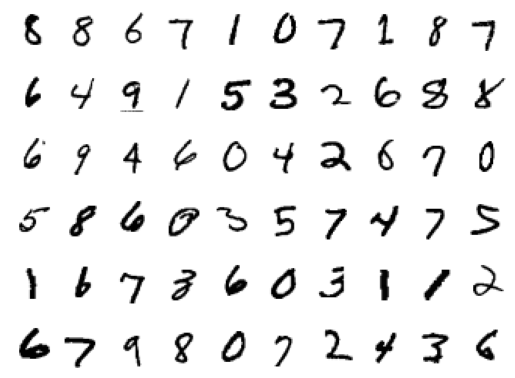

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
from model import Net1 as Net

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
            Conv2d-5           [-1, 64, 14, 14]          18,496
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 5, 5]          73,856
            Conv2d-8            [-1, 256, 3, 3]         295,168
            Conv2d-9             [-1, 10, 1, 1]          23,050
Total params: 416,458
Trainable params: 416,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 1.59
Estimated Total Size (MB): 1.97
--------------------------------------

In [9]:
from tqdm.notebook import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.1566, Accuracy: 9504/10000 (95.04%)

EPOCH: 1


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.1454, Accuracy: 9541/10000 (95.41%)

EPOCH: 2


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9782/10000 (97.82%)

EPOCH: 3


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9810/10000 (98.10%)

EPOCH: 4


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9818/10000 (98.18%)

EPOCH: 6


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9888/10000 (98.88%)

EPOCH: 9


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9903/10000 (99.03%)

EPOCH: 11


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9894/10000 (98.94%)

EPOCH: 13


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

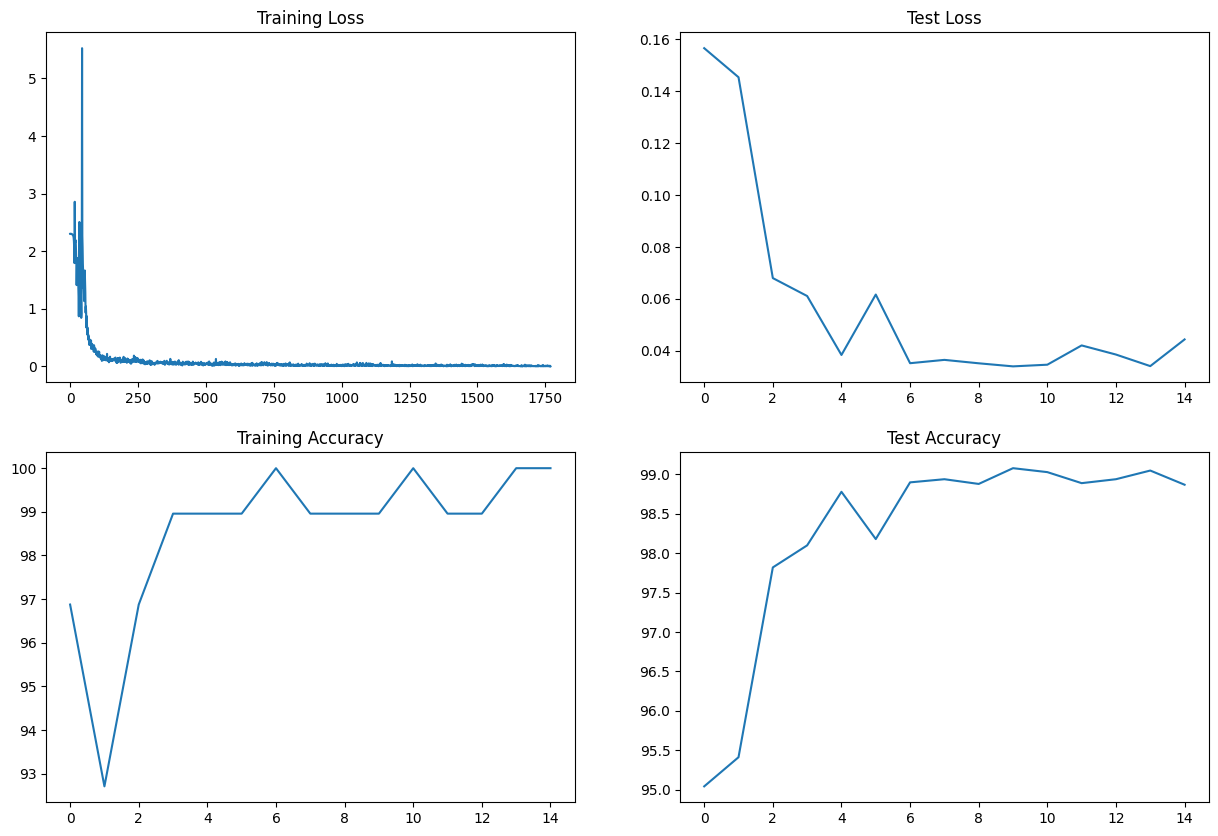

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target**:

1. Get the set-up right
2. Set Transforms
3. Set Data Loader
4. Set Basic Working Code
5. Set Basic Training  & Test Loop

**Results**:

1. Parameters: 416K
2. Best Training Accuracy: 99.73
3. Best Test Accuracy: 99.08

**Analysis**:

1. Model for such a problem but is working
2. Model is over-fitting